In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [2]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '273589987'
gj1243_tess = search_lightcurvefile(target,cadence='short').download_all()

In [3]:
gj1243_tess

LightCurveFileCollection of 12 objects:
	KIC 9726699 (11 KeplerLightCurveFiles) Quarters: 6,6,10,10,10,12,12,12,13,13,13
	TIC 273589987 (1 KeplerLightCurveFiles) None: 0

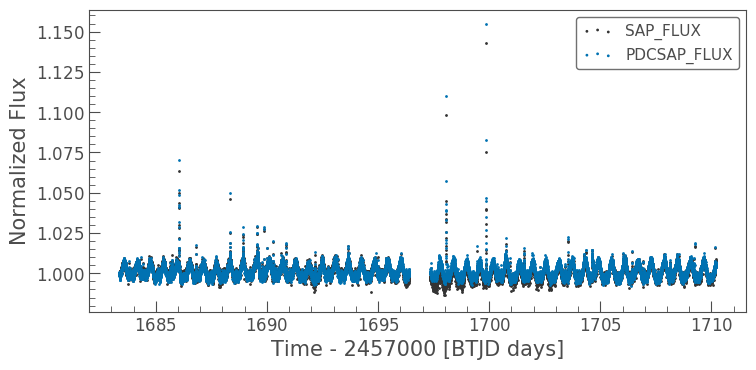

In [4]:
gj1243_tess[11].scatter()

In [5]:
fbeye = pd.read_csv('gj1243_tess_flares.dat.fbeye',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]

In [6]:
len(gj1243_tess[11].time)

18522

In [7]:
Lo=30
ED = np.sort(fbeye['Equiv_Dur'][::-1])
time = (np.nanmedian(np.diff(gj1243_tess[11].time))) * (len(gj1243_tess[11].time))
nu = (np.arange(1, len(ED)+1)) / time

x = np.log10(ED)[::-1] + (Lo)
#is is log(Lo)???
y = np.log10(nu)

Text(0.5, 1.0, 'GJ 1243 - TESS Sector 14')

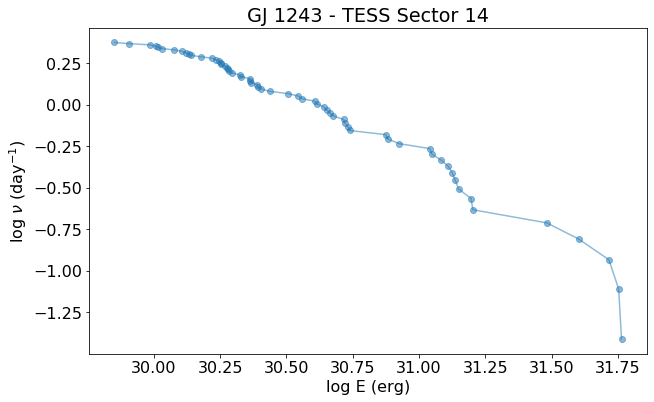

In [8]:
fig = plt.figure(figsize=(10,6))
font = {'size'   : 16}
plt.rc('font', **font)

plt.plot(x,y,'-o', color='C0', alpha=0.5)
plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.title('GJ 1243 - TESS Sector 14')

In [13]:
# Kepler Flares
kep_Lo = 30.665290     #Jim calculated this value long time ago

kep_lc = pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/1732d4130daf663532596749d566d8f78be8f7b2/data/gj1243_master_slc.dat', delim_whitespace=True, skiprows=1, 
                       names=('time', 'flux', 'error', 'detrended_flux'))
kep_dur = len(kep_lc) * 58.0 / 60./60./24.

kep_flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [14]:
kep_x = np.log10(np.sort(kep_flare_table['ED'])[::-1]) + kep_Lo
kep_y = np.log10(np.arange(1, len(kep_x)+1) / kep_dur)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


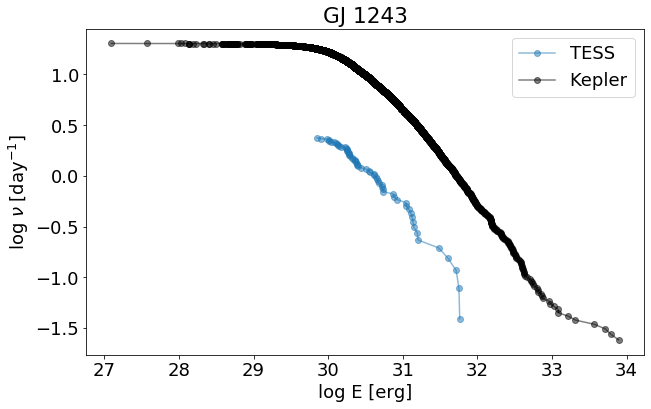

In [19]:
fig = plt.figure(figsize=(10,6))
font = {'size'   : 18}
plt.rc('font', **font)

plt.plot(x,y,'-o', color='C0', alpha=0.5, label='TESS')
plt.plot(kep_x,kep_y,'-o', color='K', alpha=0.5, label='Kepler')
plt.xlabel('log E [erg]')
plt.ylabel(r'log $\nu$ [day$^{-1}$]')
plt.title('GJ 1243')
plt.legend()